<a href="https://colab.research.google.com/github/vinayakShenoy/DL4CV/blob/master/Code/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation
- Any modification we make to a learning algorithm that is intended to reduce generalization error, but not its training error is called regularization.
- In starter bundle we learned L1 and L2 regularization.
- There exist other types of regularization that either:
  - Modify the network architecture itself
  - Augment the data passed into the network for training.
- Dropout is an example of modifying a network where a layer randomly disconnects nodes from previous layer to the next layer, thereby ensuring that no single node is responsible for learning how to represent a given class.
- Data augmentation encompasses a wide range of techniques used to generate new training samples from the original ones by applying random jitters and perturbations such that the classes labels are
not changed.
- We can obtain additional training data from the original images by apply simple geometric transforms such as random:
  - Translations
  - Rotations
  - Changes in scale
  - Shearing 
  - Horizontal flips
  - Random perturbations of colors in a given color space
  - Nonlinear geometric distortions



In [ ]:
!pip install imutils
!pip install import_ipynb
!git clone https://github.com/vinayakshenoy/DL4CV
%cd DL4CV/Code
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
!tar -xvzf 17flowers.tgz

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import import_ipynb
import cv2
import imutils
from nn.MiniVGGNet import MiniVGGNet
from preprocessing.preprocessors import ImageToArrayPreprocessor, AspectAwarePreprocessor
import shutil

/content/DL4CV/Code
importing Jupyter notebook from /content/DL4CV/Code/nn/MiniVGGNet.ipynb
importing Jupyter notebook from /content/DL4CV/Code/preprocessing/preprocessors.ipynb


In [3]:
args = {
    "dataset":"jpg",
}

# Processing Data

In [4]:
imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = sorted(imagePaths, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [5]:
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()
preprocessors = [aap, iap]

data = []
labels = []
label = 0
for (i,imagePath) in enumerate(imagePaths):
  img = cv2.imread(imagePath)
  for p in preprocessors:
    img = p.preprocess(img)
  data.append(img)
  labels.append(label)
  if i>0 and i%80==0:
    label += 1

(data, labels) = (np.array(data).astype("float")/255.0, np.array(labels))

In [106]:
print(labels)

[ 0  0  0 ... 16 16 16]


In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [7]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(1020, 64, 64, 3)
(340, 64, 64, 3)
(1020, 17)
(340, 17)


***
# Without Data Augmentation

In [8]:
print("INFO compiling model")
model = MiniVGGNet.build(width=64, height=64, depth=3, classes=trainY.shape[1])
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.05), metrics=["accuracy"])
print("INFO training network")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

INFO compiling model
INFO training network
Epoch 1/100
32/32 [==============================] - 2s 51ms/step - loss: 3.2151 - accuracy: 0.2363 - val_loss: 3.5479 - val_accuracy: 0.1735
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 1.8518 - accuracy: 0.4686 - val_loss: 2.4543 - val_accuracy: 0.2353
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 1.2704 - accuracy: 0.6059 - val_loss: 2.4652 - val_accuracy: 0.2676
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 1.0141 - accuracy: 0.6853 - val_loss: 2.8508 - val_accuracy: 0.2059
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 0.7496 - accuracy: 0.7598 - val_loss: 2.9767 - val_accuracy: 0.2176
Epoch 6/100
32/32 [==============================] - 1s 31ms/step - loss: 0.5586 - accuracy: 0.8343 - val_loss: 2.1530 - val_accuracy: 0.3882
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 0.3630 - accuracy: 0.8824 - val

INFO evaluating network
              precision    recall  f1-score   support

           0       0.38      0.47      0.42        19
           1       0.26      0.40      0.32        15
           2       0.32      0.33      0.33        21
           3       0.81      0.59      0.68        22
           4       0.47      0.42      0.44        19
           5       0.80      0.76      0.78        21
           6       0.88      0.71      0.79        21
           7       0.40      0.31      0.35        26
           8       0.71      0.62      0.67        16
           9       0.94      0.80      0.86        20
          10       0.69      0.90      0.78        20
          11       0.69      0.50      0.58        22
          12       0.47      0.56      0.51        16
          13       0.28      0.39      0.33        18
          14       0.52      0.78      0.62        18
          15       0.75      0.65      0.70        23
          16       0.88      0.65      0.75        23

  

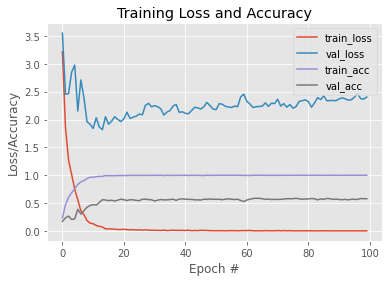

In [9]:
print("INFO evaluating network")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), target_names=[str(x) for x in np.unique(labels).tolist()]))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [13]:
print(testY.shape)
print(predictions.shape)

(340, 17)
(340, 17)


***
# With Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2,
                         zoom_range=0.2, horizontal_flip=True,
                         fill_mode="nearest")

In [12]:
print("INFO compiling model")
model = MiniVGGNet.build(width=64, height=64, depth=3, classes=trainY.shape[1])
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.05), metrics=["accuracy"])

INFO compiling model


In [14]:
print("INFO training network")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX)//32,
                        epochs=100, verbose=1)

INFO training network
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
31/31 [==============================] - 2s 69ms/step - loss: 3.4190 - accuracy: 0.1852 - val_loss: 2.7065 - val_accuracy: 0.1559
Epoch 2/100
31/31 [==============================] - 2s 61ms/step - loss: 2.3865 - accuracy: 0.3775 - val_loss: 2.8136 - val_accuracy: 0.1441
Epoch 3/100
31/31 [==============================] - 2s 61ms/step - loss: 2.1459 - accuracy: 0.4089 - val_loss: 2.7142 - val_accuracy: 0.1559
Epoch 4/100
31/31 [==============================] - 2s 62ms/step - loss: 1.8308 - accuracy: 0.4524 - val_loss: 2.9833 - val_accuracy: 0.2029
Epoch 5/100
31/31 [==============================] - 2s 62ms/step - loss: 1.7890 - accuracy: 0.4636 - val_loss: 3.3099 - val_accuracy: 0.1853
Epoch 6/100
31/31 [==============================] - 2s 61ms/step - loss: 1.5985 - accuracy: 0.5051 - val_loss: 2.5776 - val_accuracy: 0.2676
Epoch 7/100
31/31 [==============================]

In [16]:
print("INFO evaluating network")
predictions = model.predict(testX, batch_size=32)

INFO evaluating network


              precision    recall  f1-score   support

           0       0.41      0.37      0.39        19
           1       0.32      0.40      0.35        15
           2       0.57      0.57      0.57        21
           3       0.78      0.64      0.70        22
           4       0.64      0.74      0.68        19
           5       0.89      0.81      0.85        21
           6       0.94      0.81      0.87        21
           7       0.61      0.42      0.50        26
           8       0.74      0.88      0.80        16
           9       0.94      0.85      0.89        20
          10       0.90      0.90      0.90        20
          11       0.75      0.68      0.71        22
          12       0.93      0.81      0.87        16
          13       0.63      0.67      0.65        18
          14       0.41      0.78      0.54        18
          15       0.81      0.74      0.77        23
          16       0.91      0.91      0.91        23

    accuracy              

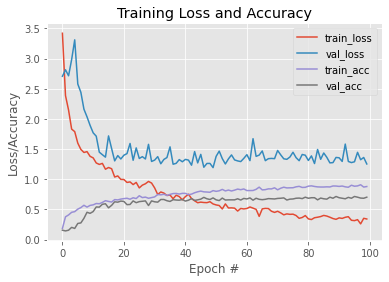

In [17]:
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=[str(x) for x in np.unique(labels).tolist()]))

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()